In [1]:
import torch
import pandas as pd
import numpy as np

# Import dataset utils
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import importlib
if importlib.util.find_spec('ipywidgets') is not None:
    from tqdm.auto import tqdm
else:
    from tqdm import tqdm

import networkx as nx

from typing import Union

In [2]:
dataframe = pd.read_csv('../data/final.csv', sep=';')

dataframe = dataframe.drop(['Chave'], axis=1)
dataframe = dataframe.fillna(-1)
dataframe['Anos educacao formal'] = dataframe['Anos educacao formal'].replace(-5, -1)
dataframe['sexo'].replace({'M': 0, 'F': 1}, inplace=True)
df_suic = dataframe.copy()
df_suic = df_suic.astype(float)
df_suic.shape

(3953, 68)

In [3]:
# print collumns
df_suic.columns

Index(['sexo', 'Estado_civil', 'Status_empl', 'Licenca', 'Tipo_Resid',
       'Residencia', 'Alcoolatra', 'Droga', 'Suic_familia', 'Dep_familia',
       'Bip_familia', 'Alc_familia', 'Drog_familia', 'coracao', 'vascular',
       'hematopoetico', 'Olho_ore_nariz_garg_lar', 'GI_sup', 'Gi_inf', 'Renal',
       'Genito_urinario', 'Musculoesqueletico', 'Neuro', 'psiquiatrica',
       'Respiratorio', 'Figado', 'Endocrino_metabolico',
       'Anos educacao formal', 'Capaz de desfrutar das coisas',
       'Impacto de sua familia e amigos',
       'Numero de amigos vivendo com paciente',
       'Capaz de tomar decisões importantes',
       'Numero de parentes vivendo com paciente',
       'Conjuge_companheiro vive com paciente', 'Estudante',
       'Numero total de pessoas em casa', 'Receber dinheiro do emprego',
       'Renda mensal', 'Recebe assistencia publica', 'Insonia',
       'Insonia media', 'Insonia tardia', 'Deprimido', 'Ansiedade',
       'Perda de insights', 'Apetite', 'Perda de pes

In [4]:
notears_selected = [
    "Suic_familia",
    "Drog_familia",
    "Capaz de tomar decisões importantes",
    "Estudante",
    "Hipocondriase",
    "Sentimentos_culpa",
    "Trabalho e interesses",
    "Energia",
    "Lentidao pensamento e fala",
    "Perda de insights",

    "Suicidio",
    "Ansiedade",
   
]

# Create datasets

The first one is normal and the second has the graph structur

In [5]:
def adj_to_edge_index(adj):
    edge_index = []
    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            edge_index.append([i, j])
    return torch.tensor(edge_index, dtype=torch.float).t().contiguous()

# Dataset from X 
class CausalDataset(Dataset):
    def __init__(self, X, target:Union[list, int]):
        self.X = torch.tensor(X, dtype=torch.double)
        self.target = target
        if isinstance(target, int):
            self.target = [target]
        

        # X is every variable except the target list
        dims = list(range(self.X.shape[1]))
        self.x = self.X[:, [i for i in dims if i not in self.target]]
        self.y = self.X[:, self.target]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx].double(), self.y[idx].double()

from torch_geometric.data import Data

class CausalGraphDataset(Dataset):
    def __init__(self, X, target, adj_matrix):
        self.X = torch.tensor(X, dtype=torch.double)
        self.adj_matrix = torch.tensor(adj_matrix, dtype=torch.double)
        self.edge_index = adj_to_edge_index(self.adj_matrix).long()
        self.target = target

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].clone()
        x[self.target] = 0
        x = x.unsqueeze(-1)
        return Data(x=x, edge_index=self.edge_index), self.X[idx, self.target]

# Create Models

In [6]:
from torch_geometric.nn import models as GeometricModels

# Create a MLP that takes as input a list of dimensions
class MLP(torch.nn.Module):
    def __init__(self, dim_list:list, add_dropout:bool=False):
        super(MLP, self).__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(dim_list) - 2):
            self.layers.append(torch.nn.Linear(dim_list[i], dim_list[i+1]))
            self.layers.append(torch.nn.ReLU())
            if add_dropout:
                self.layers.append(torch.nn.Dropout(0.3))

        self.layers.append(torch.nn.Linear(dim_list[-2], dim_list[-1]))
        self.double()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class GCN(torch.nn.Module):
    def __init__(self, input_dim:int, hidden_dim:int, output_dim:int, n_layers:int, target:Union[list, int]):
        super(GCN, self).__init__()

        self.target = target
        if isinstance(target, int):
            self.target = [target]

        self.net = GeometricModels.GCN(in_channels=input_dim, hidden_channels=hidden_dim, out_channels=output_dim, num_layers=n_layers)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        y_hat = self.net(x, edge_index)

        # check if data has batch
        if hasattr(data, 'batch'):
            batch_size = data.batch[-1].item() + 1
            reshaped_y_hat = y_hat.reshape(batch_size, -1)
            return reshaped_y_hat[:, self.target]
        else:
            return y_hat[self.target]

# Out train pipeline

In [26]:
def trainPipeline(dataset, model, batch_size=64, train_split=0.8, verbose=True, max_epochs=100, patience=10, lr=0.001, weight_decay=0.0, loss_fn=nn.MSELoss()):
    train_size = int(train_split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    criterion = loss_fn
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    patience = patience

    train_losses = []
    test_losses = []
    for epoch in tqdm(range(max_epochs)):
        train_loss = 0
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        test_loss = 0
        model.eval()
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        if verbose:
            print(f"Epoch {epoch} - Train loss: {train_loss} - Test loss: {test_loss}")

        # add early stopping with patience variable
        if epoch > 10:
            all_patience = test_losses[-patience:]
            test_loss = test_losses[-1]
            if all([test_loss > x for x in all_patience]):
                print("Early stopping")
                break


    # test model on test set and calculate accuracy
    model.eval()
    with torch.no_grad():
        y_pred_test = []
        y_true_test = []
        y_pred_train = []
        y_true_train = []

        for data, target in train_loader:
            output = model(data)
            y_pred_train.append(output)
            y_true_train.append(target)
        for data, target in test_loader:
            output = model(data)
            y_pred_test.append(output)
            y_true_test.append(target)

        y_pred_test = torch.cat(y_pred_test, dim=0)
        y_true_test = torch.cat(y_true_test, dim=0)
        y_pred_train = torch.cat(y_pred_train, dim=0)
        y_true_train = torch.cat(y_true_train, dim=0)

        train_error = torch.abs(y_pred_train - y_true_train)
        test_error = torch.abs(y_pred_test - y_true_test)

        # calculate accuracy for each target
        test_accuracy = []
        train_accuracy = []
        for i in range(len(y_true_test[0])):
            test_accuracy.append(torch.sum(test_error[:, i] < 0.5) / len(test_error))
            train_accuracy.append(torch.sum(train_error[:, i] < 0.5) / len(train_error))      

        print(f"Final Train accuracy: {train_accuracy}")
        print(f"Final Test accuracy: {test_accuracy}")      

    metrics = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_error": train_error,
        "test_error": test_error,
        "test_accuracy": test_accuracy
    }

    return model, metrics


# Now we train the conterfactual net without causal features selecion

## First train one model for each target and get errors value

  0%|          | 1/300 [00:00<00:35,  8.52it/s]

Final Train accuracy: [tensor(0.6762)]
Final Test accuracy: [tensor(0.6612)]


100%|██████████| 300/300 [00:36<00:00,  8.24it/s]


Final Train accuracy: [tensor(0.7473)]
Final Test accuracy: [tensor(0.7219)]


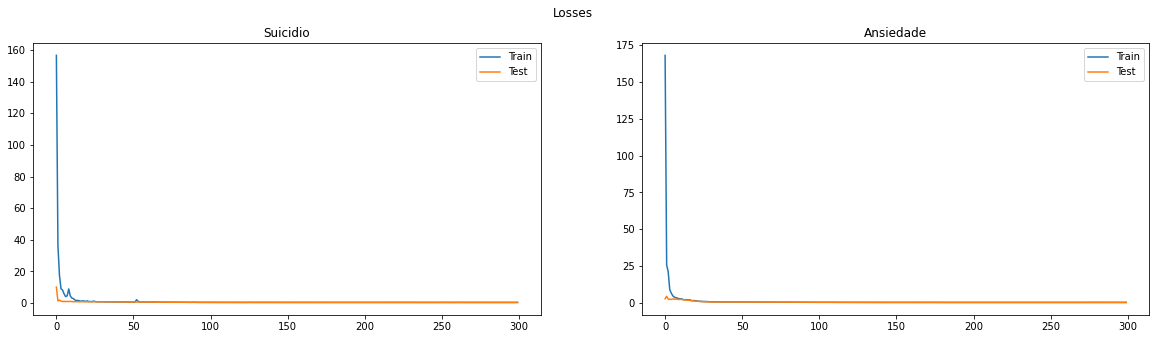

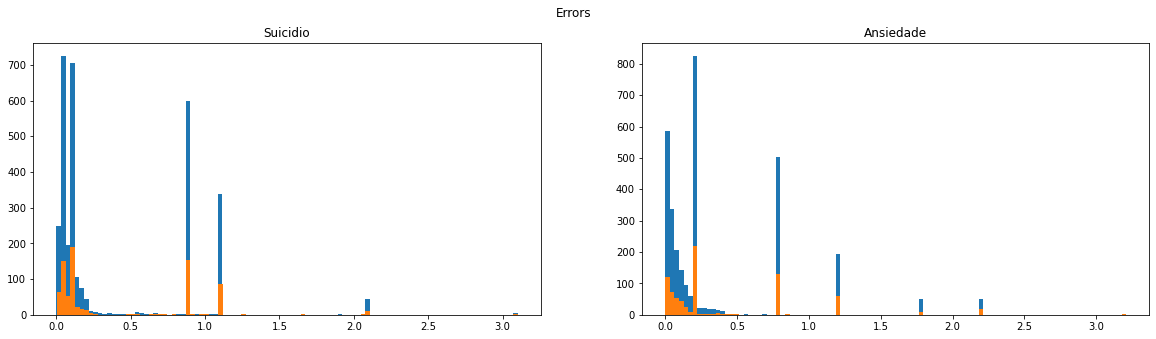

In [37]:
# get the target collumns indexes
targets = ["Suicidio", "Ansiedade"]
targets_idx = [df_suic.columns.get_loc(c) for c in targets]

# Create the dataset
suic_dataset = CausalDataset(df_suic.values, targets_idx[0])
anx_dataset = CausalDataset(df_suic.values, targets_idx[1])
sample_x, sample_y = suic_dataset[0]

# Now we predict the first target with a MLP
suic_model = MLP([sample_x.shape[0], 64, 64, 64, 1], add_dropout=True)
anx_model = MLP([sample_x.shape[0], 64, 64, 64, 1], add_dropout=True)

suic_model, suic_metrics = trainPipeline(suic_dataset, suic_model, verbose=False, max_epochs=300, weight_decay=1e-5)
anx_model, anx_metrics = trainPipeline(anx_dataset, anx_model, verbose=False, max_epochs=300, weight_decay=1e-5)

# plot the losses with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Losses")
axs[0].plot(suic_metrics["train_loss"], label="Train")
axs[0].plot(suic_metrics["test_loss"], label="Test")
axs[0].set_title("Suicidio")
axs[0].legend()

axs[1].plot(anx_metrics["train_loss"], label="Train")
axs[1].plot(anx_metrics["test_loss"], label="Test")
axs[1].set_title("Ansiedade")
axs[1].legend()

plt.show()


#  plot errors hist with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Errors")
axs[0].hist(suic_metrics["train_error"][:,0], label="Train", bins=100)
axs[0].hist(suic_metrics["test_error"][:,0], label="Test", bins=100)
axs[0].set_title("Suicidio")

axs[1].hist(anx_metrics["train_error"][:,0], label="Train", bins=100)
axs[1].hist(anx_metrics["test_error"][:,0], label="Test", bins=100)
axs[1].set_title("Ansiedade")

plt.show()

## Now add the errors to the dataset and train the counterfactual model

In [38]:
# Create the counterfactual model 

class CounterfactualModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CounterfactualModel, self).__init__()
        self.individuality_model = MLP([input_size, hidden_size, hidden_size, hidden_size, 1], add_dropout=True)
        self.counterfactual_model = MLP([input_size+1, hidden_size, hidden_size, hidden_size, output_size], add_dropout=True)

    def individuality(self, x):
        return self.individuality_model(x)
    
    def counterfactual(self, x, i):
        x = torch.cat([x, i], dim=1)
        return self.counterfactual_model(x)
    
    def forward(self, x):
        i = self.individuality(x)
        y = self.counterfactual(x, i)
        return y


100%|██████████| 300/300 [00:58<00:00,  5.12it/s]


Final Train accuracy: [tensor(0.6157), tensor(0.6891)]
Final Test accuracy: [tensor(0.5158), tensor(0.5891)]


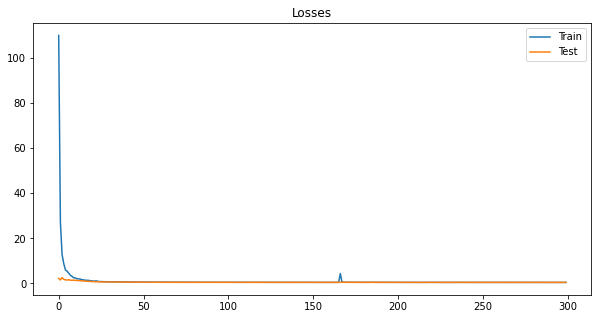

In [39]:
# calculate errors
suic_erros = []
anx_erros = []
with torch.no_grad():
    for data, y_true in suic_dataset:
        y_pred = suic_model(data)
        error = torch.abs(y_pred - y_true).item()
        suic_erros.append(error)
    for data, y_true in anx_dataset:
        y_pred = anx_model(data)
        error = torch.abs(y_pred - y_true).item()
        anx_erros.append(error)

suic_erros = np.array(suic_erros)
anx_erros = np.array(anx_erros)

# add errors to the dataframe   
df_suic_with_errors = df_suic.copy()
df_suic_with_errors["Suicidio_error"] = suic_erros
df_suic_with_errors["Ansiedade_error"] = anx_erros

# create the causal dataset with the errors
targets_idx = [df_suic_with_errors.columns.get_loc(c) for c in targets]
causal_dataset_error = CausalDataset(df_suic_with_errors.values, targets_idx)
sample_x, sample_y = causal_dataset_error[0]

# create the counterfactual model
cf_model = CounterfactualModel(sample_x.shape[0], 64, sample_y.shape[0])

# train the counterfactual model
cf_model, cf_metrics = trainPipeline(causal_dataset_error, cf_model, verbose=False, max_epochs=300, weight_decay=1e-5)

# plot the losses 
plt.figure(figsize=(10, 5))
plt.plot(cf_metrics["train_loss"], label="Train")
plt.plot(cf_metrics["test_loss"], label="Test")
plt.title("Losses")
plt.legend()
plt.show()


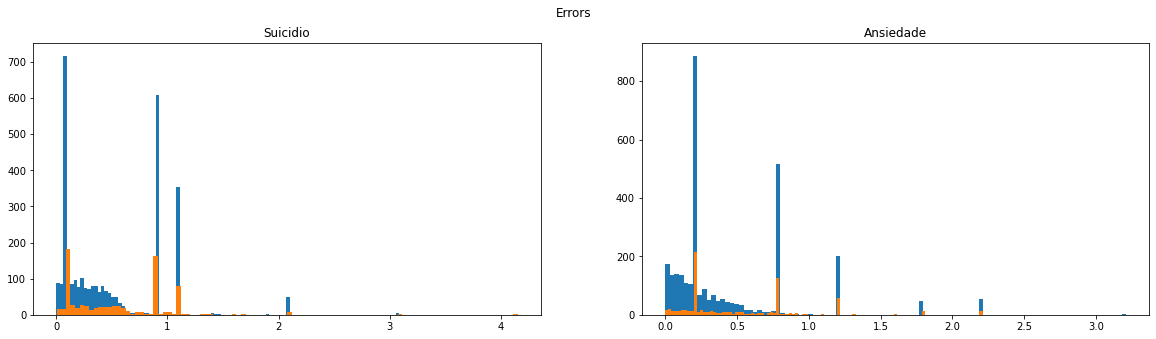

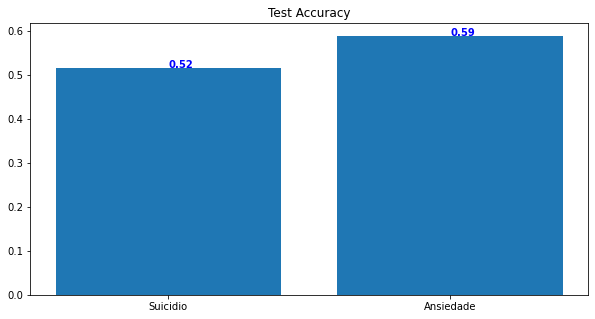

In [49]:
# plot the errors
n_targets = len(targets)
fig, axs = plt.subplots(1, n_targets, figsize=(20, 5))
fig.suptitle("Errors")
for i in range(n_targets):
    axs[i].hist(cf_metrics["train_error"][:,i], label="Train", bins=100)
    axs[i].hist(cf_metrics["test_error"][:,i], label="Test", bins=100)
    axs[i].set_title(targets[i])
plt.show()

# plot cf_metrics['test_accuracy'] bars with target names
plt.figure(figsize=(10, 5))
plt.bar(targets, cf_metrics["test_accuracy"])
plt.title("Test Accuracy")
# add the values to the bars
for i, v in enumerate(cf_metrics["test_accuracy"]):
    plt.text(i, v, str(round(v.item(), 2)), color='blue', fontweight='bold')
plt.show()


# Now we are going to redo everything, but with the NOTEAR features

  0%|          | 1/1000 [00:00<01:57,  8.47it/s]

Final Train accuracy: [tensor(0.5443)]
Final Test accuracy: [tensor(0.4273)]


100%|██████████| 1000/1000 [01:55<00:00,  8.69it/s]


Final Train accuracy: [tensor(0.5465)]
Final Test accuracy: [tensor(0.4627)]


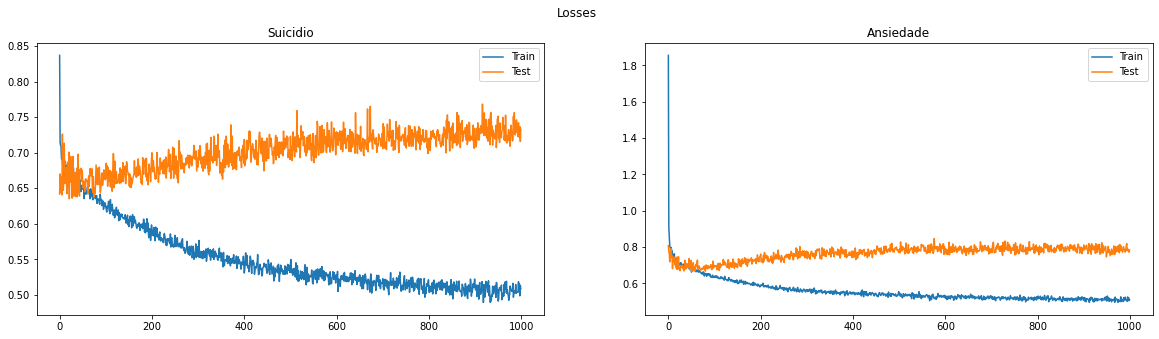

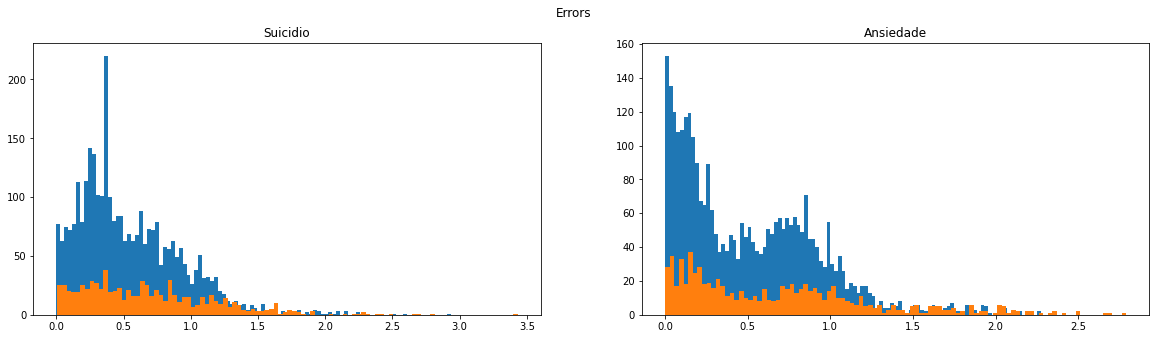

In [50]:
df_suic_notears = df_suic.copy()
df_suic_notears = df_suic_notears[notears_selected]

# create models for each target
targets = ["Suicidio", "Ansiedade"]
targets_idx = [df_suic_notears.columns.get_loc(c) for c in targets]

# Create the dataset
notears_suic_dataset = CausalDataset(df_suic_notears.values, targets_idx[0])
notears_anx_dataset = CausalDataset(df_suic_notears.values, targets_idx[1])
sample_x, sample_y = notears_suic_dataset[0]

# Now we predict the targets with a MLP
suic_causal_model = MLP([sample_x.shape[0], 64, 64, 64, 1], add_dropout=True)
anx_causal_model = MLP([sample_x.shape[0], 64, 64, 64, 1], add_dropout=True)

suic_causal_model, suic_causal_metrics = trainPipeline(notears_suic_dataset, suic_causal_model, verbose=False, max_epochs=1000, weight_decay=1e-5)
anx_causal_model, anx_causal_metrics = trainPipeline(notears_anx_dataset, anx_causal_model, verbose=False, max_epochs=1000, weight_decay=1e-5)

# plot the losses with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Losses")
axs[0].plot(suic_causal_metrics["train_loss"], label="Train")
axs[0].plot(suic_causal_metrics["test_loss"], label="Test")
axs[0].set_title("Suicidio")
axs[0].legend()

axs[1].plot(anx_causal_metrics["train_loss"], label="Train")
axs[1].plot(anx_causal_metrics["test_loss"], label="Test")
axs[1].set_title("Ansiedade")
axs[1].legend()

plt.show()

#  plot errors hist with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Errors")
axs[0].hist(suic_causal_metrics["train_error"][:,0], label="Train", bins=100)
axs[0].hist(suic_causal_metrics["test_error"][:,0], label="Test", bins=100)
axs[0].set_title("Suicidio")

axs[1].hist(anx_causal_metrics["train_error"][:,0], label="Train", bins=100)
axs[1].hist(anx_causal_metrics["test_error"][:,0], label="Test", bins=100)
axs[1].set_title("Ansiedade")

plt.show()

In [53]:
# calculate errors
suic_causal_erros = []
anx_causal_erros = []
with torch.no_grad():
    for data, y_true in notears_suic_dataset:
        y_pred = suic_causal_model(data)
        error = torch.abs(y_pred - y_true).item()
        suic_causal_erros.append(error)
    for data, y_true in notears_anx_dataset:
        y_pred = anx_causal_model(data)
        error = torch.abs(y_pred - y_true).item()
        anx_causal_erros.append(error)

suic_causal_erros = np.array(suic_causal_erros)
anx_causal_erros = np.array(anx_causal_erros)

# add errors to the dataframe   
df_suic_notears_with_errors = df_suic_notears.copy()
df_suic_notears_with_errors["Suicidio_error"] = suic_causal_erros
df_suic_notears_with_errors["Ansiedade_error"] = anx_causal_erros

# create the causal dataset with the errors
targets_idx = [df_suic_notears_with_errors.columns.get_loc(c) for c in targets]
notears_causal_dataset_error = CausalDataset(df_suic_notears_with_errors.values, targets_idx)
sample_x, sample_y = notears_causal_dataset_error[0]

# create the counterfactual model
causal_cf_model = CounterfactualModel(sample_x.shape[0], 64, sample_y.shape[0])

# train the counterfactual model
causal_cf_model, causal_cf_metrics = trainPipeline(notears_causal_dataset_error, causal_cf_model, verbose=False, max_epochs=1000, weight_decay=1e-5)


100%|██████████| 1000/1000 [03:14<00:00,  5.13it/s]

Final Train accuracy: [tensor(0.8087), tensor(0.7577)]
Final Test accuracy: [tensor(0.7118), tensor(0.6675)]


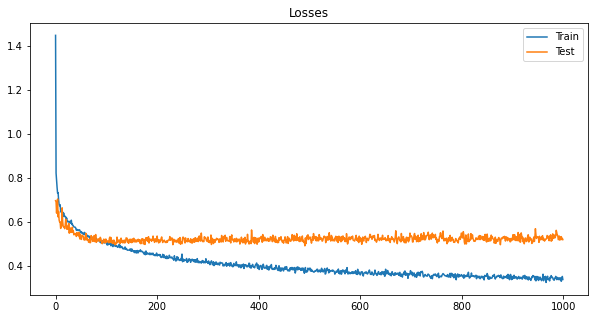

In [55]:
# plot the losses 
plt.figure(figsize=(10, 5))
plt.plot(causal_cf_metrics["train_loss"], label="Train")
plt.plot(causal_cf_metrics["test_loss"], label="Test")
plt.title("Losses")
plt.legend()
plt.show()


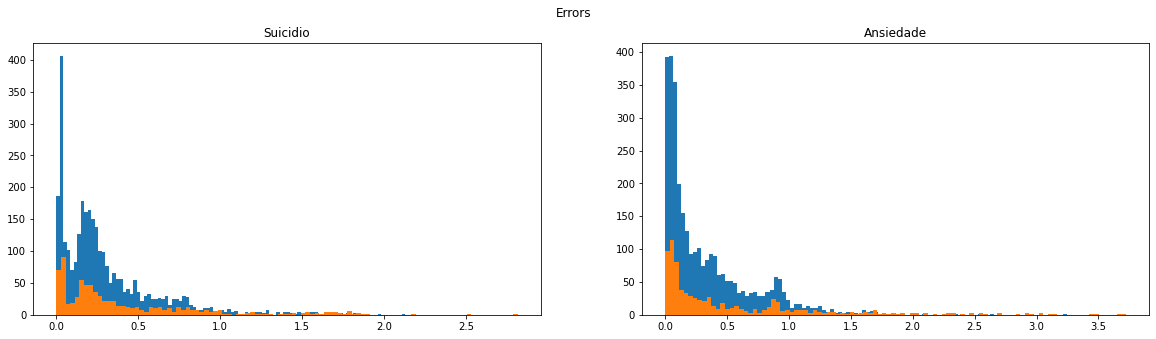

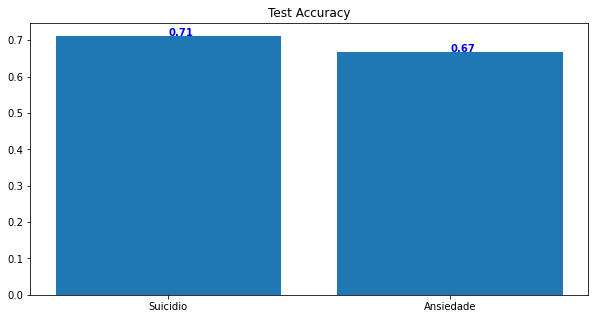

In [54]:
# plot the errors
n_targets = len(targets)
fig, axs = plt.subplots(1, n_targets, figsize=(20, 5))
fig.suptitle("Errors")
for i in range(n_targets):
    axs[i].hist(causal_cf_metrics["train_error"][:,i], label="Train", bins=100)
    axs[i].hist(causal_cf_metrics["test_error"][:,i], label="Test", bins=100)
    axs[i].set_title(targets[i])
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(targets, causal_cf_metrics["test_accuracy"])
plt.title("Test Accuracy")
# add the values to the bars
for i, v in enumerate(causal_cf_metrics["test_accuracy"]):
    plt.text(i, v, str(round(v.item(), 2)), color='blue', fontweight='bold')
plt.show()



In [60]:
!mkdir cf_models

# save everything
torch.save(causal_cf_model, "cf_models/causal_cf_model.pt")
torch.save(causal_cf_metrics, "cf_models/causal_cf_metrics.pt")

torch.save(suic_causal_model, "cf_models/suic_causal_model.pt")
torch.save(suic_causal_metrics, "cf_models/suic_causal_metrics.pt")

torch.save(anx_causal_model, "cf_models/anx_causal_model.pt")
torch.save(anx_causal_metrics, "cf_models/anx_causal_metrics.pt")

# save the non causal models also
torch.save(cf_model, "cf_models/cf_model.pt")
torch.save(cf_metrics, "cf_models/cf_metrics.pt")

torch.save(suic_model, "cf_models/suic_model.pt")
torch.save(suic_metrics, "cf_models/suic_metrics.pt")

torch.save(anx_model, "cf_models/anx_model.pt")
torch.save(anx_metrics, "cf_models/anx_metrics.pt")

# save the dataframes
df_suic.to_csv("cf_models/df_suic.csv", index=False)
df_suic_with_errors.to_csv("cf_models/df_suic_with_errors.csv", index=False)

df_suic_notears_with_errors.to_csv("cf_models/df_suic_notears_with_errors.csv", index=False)
df_suic_notears.to_csv("cf_models/df_suic_notears.csv", index=False)

mkdir: cannot create directory ‘cf_models’: File exists


# Couterfacting

In [90]:
# Load the dataset
targets = ["Suicidio", "Ansiedade"]
df = pd.read_csv("cf_models/df_suic_notears_with_errors.csv")
# print available columns
# print possible values for each column
for col in df.columns:
    if "error" not in col:
        print(f"{col}: {sorted(df[col].unique())}")

# load models
counterfact = torch.load("cf_models/causal_cf_model.pt")
counterfact = counterfact.eval()

Suic_familia: [0.0, 1.0]
Drog_familia: [0.0, 1.0]
Capaz de tomar decisões importantes: [-1.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Estudante: [-1.0, 0.0, 0.5, 1.0]
Hipocondriase: [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
Sentimentos_culpa: [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
Trabalho e interesses: [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
Energia: [-1.0, 0.0, 1.0, 2.0]
Lentidao pensamento e fala: [-1.0, 0.0, 1.0, 2.0, 3.0]
Perda de insights: [-1.0, 0.0, 1.0, 2.0]
Suicidio: [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
Ansiedade: [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


In [96]:
cf_coll = 'Sentimentos_culpa'

df_test = df[(df["Suicidio"] == 4) & (df[cf_coll] > 2)]
cf_data = CausalDataset(df_test.values, [df_test.columns.get_loc(c) for c in targets])

cf_idx = df_test.columns.get_loc(cf_coll)

# predict the counterfactuals
with torch.no_grad():
    new_cf = []
    for data, y_true in cf_data:
        data = data.unsqueeze(0)
        i = counterfact.individuality(data)
        data[0, cf_idx] = 0
        cf = counterfact.counterfactual(data, i)
        cf = cf.squeeze(0).round().numpy().tolist()
        new_cf.append(cf)

    new_cf = np.array(new_cf)

df_test["Ansiedade_cf"] = new_cf[:, 0]
df_test["Suicidio_cf"] = new_cf[:, 1]

print("Counterfact individuals to remove Suic_familia")
df_test[['Ansiedade', 'Ansiedade_cf', 'Suicidio', 'Suicidio_cf']]

Counterfact individuals to remove Suic_familia


<ipython-input-96-12b76c80113b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Ansiedade_cf"] = new_cf[:, 0]
<ipython-input-96-12b76c80113b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Suicidio_cf"] = new_cf[:, 1]


,Ansiedade,Ansiedade_cf,Suicidio,Suicidio_cf
188,2.0,2.0,4.0,2.0
689,3.0,3.0,4.0,2.0
948,2.0,2.0,4.0,3.0
1909,3.0,3.0,4.0,2.0
2295,3.0,3.0,4.0,2.0
2552,2.0,3.0,4.0,2.0
2868,3.0,2.0,4.0,1.0
3600,4.0,2.0,4.0,2.0


In [102]:
# Select two random individuals
dataset = CausalDataset(df.values, [df.columns.get_loc(c) for c in targets])
idx = np.random.choice(df.index, 2, replace=False)

data1, y1 = dataset[idx[0]]
data2, y2 = dataset[idx[1]]

# predict the counterfactuals for crossed individuals
with torch.no_grad():
    i1 = counterfact.individuality(data1.unsqueeze(0))
    i2 = counterfact.individuality(data2.unsqueeze(0))

    cf11 = counterfact.counterfactual(data1.unsqueeze(0), i1)
    cf12 = counterfact.counterfactual(data1.unsqueeze(0), i2)

    print("Counterfactuals for individual 1")
    print(f"Individuality: {i1.item()}, {i2.item()}")
    print(f"Counterfactual 1: {cf11.squeeze(0).round().numpy().tolist()}")
    print(f"Counterfactual 2: {cf12.squeeze(0).round().numpy().tolist()}")
    print()


Counterfactuals for individual 1
Individuality: -0.007154354119475348, -1.30420118456217
Counterfactual 1: [2.0, 2.0]
Counterfactual 2: [1.0, 2.0]



In [105]:
# Print df at idxs
df.loc[idx]

,Suic_familia,Drog_familia,Capaz de tomar decisões importantes,Estudante,Hipocondriase,Sentimentos_culpa,Trabalho e interesses,Energia,Lentidao pensamento e fala,Perda de insights,Suicidio,Ansiedade,Suicidio_error,Ansiedade_error
3398,0.0,0.0,2.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,2.0,3.0,0.624593,0.662226
297,0.0,0.0,2.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,1.0,2.0,0.332775,0.039236


In [106]:
idx

array([3398,  297])